In [175]:
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import statsmodels.api as sm

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, acf
from statsmodels.graphics.tsaplots import plot_pacf, pacf
import holidays
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_absolute_percentage_error

# Final model at the very bottom

# Load data
- multivariate data for our group uses weekly deaths
- our univariate models required a separate daily dataset for each region because we didn't have enough observations in our weekly dataset once we split by region

In [176]:
data=pd.read_csv('final data/finaldataall.csv', parse_dates=[0])
print(data.shape)
data.tail()

(7306, 146)


,date,location,year,mmwr_week,covid_19_deaths,distributed,distributed_janssen,distributed_moderna,distributed_pfizer,distributed_novavax,...,quarter,dayofyear,dayofmonth,weekofyear,holidays_Holiday,holidays_Normal_day,month_sin,month_cos,dayofweek_sin,dayofweek_cos
7301,2023-02-25,CO,2023,8,22.0,17340235.0,501900.0,6060640.0,10749595.0,28100.0,...,1,56,25,8,0,1,0.866025,0.5,-0.974928,-0.222521
7302,2023-02-25,MI,2023,8,69.0,28917130.0,967600.0,11182320.0,16740610.0,26600.0,...,1,56,25,8,0,1,0.866025,0.5,-0.974928,-0.222521
7303,2023-02-25,MD,2023,8,45.0,21829280.0,616400.0,7305760.0,13876420.0,30700.0,...,1,56,25,8,0,1,0.866025,0.5,-0.974928,-0.222521
7304,2023-02-25,LA,2023,8,24.0,10141420.0,330300.0,4094680.0,5707940.0,8500.0,...,1,56,25,8,0,1,0.866025,0.5,-0.974928,-0.222521
7305,2023-02-25,NM,2023,8,10.0,6047345.0,190600.0,2338600.0,3511145.0,7000.0,...,1,56,25,8,0,1,0.866025,0.5,-0.974928,-0.222521


In [177]:
data.columns.to_list()

['date',
 'location',
 'year',
 'mmwr_week',
 'covid_19_deaths',
 'distributed',
 'distributed_janssen',
 'distributed_moderna',
 'distributed_pfizer',
 'distributed_novavax',
 'distributed_unk_manuf',
 'dist_per_100k',
 'distributed_per_100k_5plus',
 'distributed_per_100k_12plus',
 'distributed_per_100k_18plus',
 'distributed_per_100k_65plus',
 'administered',
 'administered_5plus',
 'administered_12plus',
 'administered_18plus',
 'administered_65plus',
 'administered_janssen',
 'administered_moderna',
 'administered_pfizer',
 'administered_novavax',
 'administered_unk_manuf',
 'admin_per_100k',
 'admin_per_100k_5plus',
 'admin_per_100k_12plus',
 'admin_per_100k_18plus',
 'admin_per_100k_65plus',
 'recip_administered',
 'administered_dose1_recip',
 'administered_dose1_pop_pct',
 'administered_dose1_recip_5plus',
 'administered_dose1_recip_5plus_pop_pct',
 'administered_dose1_recip_12plus',
 'administered_dose1_recip_12plus_pop_pct',
 'administered_dose1_recip_18plus',
 'administered_d

In [178]:
data.rename(columns = {'covid_19_deaths': 'weekly_deaths'}, inplace = True)

In [179]:
data = data.drop(['location', 'date.1'], axis = 1)

In [180]:
data.fillna(0, inplace = True)

In [181]:
data['date'] = pd.to_datetime(data['date'])

In [182]:
data.head()

,date,year,mmwr_week,weekly_deaths,distributed,distributed_janssen,distributed_moderna,distributed_pfizer,distributed_novavax,distributed_unk_manuf,...,quarter,dayofyear,dayofmonth,weekofyear,holidays_Holiday,holidays_Normal_day,month_sin,month_cos,dayofweek_sin,dayofweek_cos
0,2020-01-04,2020,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,4,4,1,0,1,0.5,0.866025,-0.974928,-0.222521
1,2020-01-04,2020,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,4,4,1,0,1,0.5,0.866025,-0.974928,-0.222521
2,2020-01-04,2020,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,4,4,1,0,1,0.5,0.866025,-0.974928,-0.222521
3,2020-01-04,2020,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,4,4,1,0,1,0.5,0.866025,-0.974928,-0.222521
4,2020-01-04,2020,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,4,4,1,0,1,0.5,0.866025,-0.974928,-0.222521


In [183]:
data.set_index('date', inplace=True)

# splitting into train test

In [184]:
# Date for splitting training and testing dataset
train_end_date = '2023-01-01'

In [185]:
train = data[data.index < train_end_date]
test = data[data.index >= train_end_date]
print(train.shape, test.shape)

(6974, 143) (332, 143)


# Building baseline models

- conclusion is that the baseline model has an MAE of about 146
  
AFTER adding changepoints the baseline model is pretty good
- baseline model with changepoints is good: MAE 72
- add seasonality: MAE 77
- add seasonality and holidays: MAE 74

In [303]:
def MASE(Actual, Predicted):
    n = len(Actual)
    
    mae = mean_absolute_error(Actual, Predicted)

    # Calculate the denominator
    denominator = 1 / (n - 1) * np.sum(np.abs(Predicted[1:] - Actual[:-1]))

    # Avoid division by zero or small denominators
    if denominator > 1e-6:
        mase = mae / denominator
    else:
        mase = np.inf

    return mase

### 1. baseline model without additional regressors

23:50:46 - cmdstanpy - INFO - Chain [1] start processing
23:50:47 - cmdstanpy - INFO - Chain [1] done processing


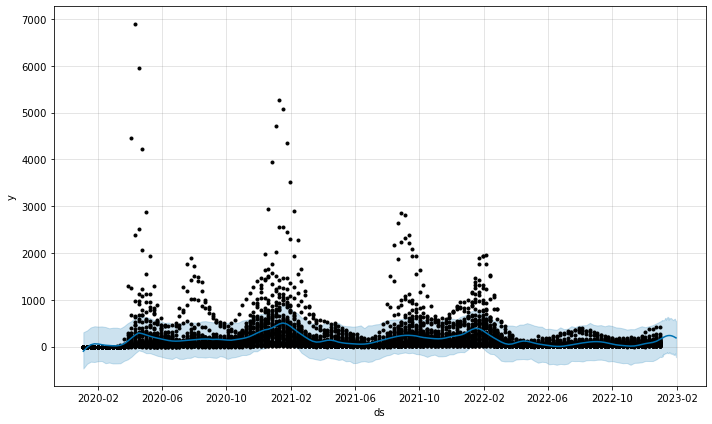

In [187]:
# Use the default hyperparameters to initiate the Prophet model
model_baseline = Prophet()

# Fit the model on the training dataset
model_baseline.fit(train.reset_index().rename(columns={'date':'ds', 'weekly_deaths':'y'}))

# 30 day forecase
future_baseline = model_baseline.make_future_dataframe(periods=30)

# Make prediction
forecast_baseline = model_baseline.predict(future_baseline)

# Visualize the forecast
model_baseline.plot(forecast_baseline); # Add semi-colon to remove the duplicated chart

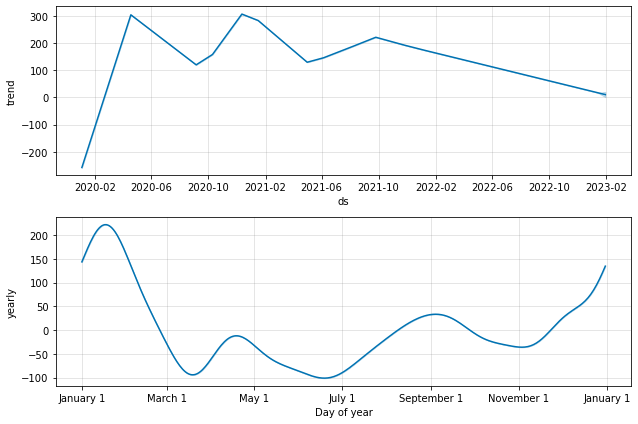

In [188]:
# Visualize the forecast components
model_baseline.plot_components(forecast_baseline);

In [304]:
# Merge actual and predicted values
performance_baseline = pd.merge(test.reset_index().rename(columns={'date':'ds', 'weekly_deaths':'y'}), forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-30:], on='ds')

# Check MAE value
performance_baseline_MAE = mean_absolute_error(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAE for the baseline model is {performance_baseline_MAE}')

# Check MAPE value
performance_baseline_MAPE = mean_absolute_percentage_error(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAPE for the baseline model is {performance_baseline_MAPE}')

The MAE for the baseline model is 146.8167401878676
The MAPE for the baseline model is 5.0116286368590695


### 2. tuning changepoints

In [190]:
# Default change points
dff = train.reset_index().rename(columns={'date':'ds', 'weekly_deaths':'y'})
print(f'There are {len(model_baseline.changepoints)} change points. \nThe change points dates are \n{dff.loc[dff["ds"].isin(model_baseline.changepoints)]}')

There are 25 change points. 
The change points dates are 
             ds  year  mmwr_week     y  distributed  distributed_janssen  \
198  2020-02-01  2020          5   0.0          0.0                  0.0   
199  2020-02-01  2020          5   0.0          0.0                  0.0   
200  2020-02-01  2020          5   0.0          0.0                  0.0   
201  2020-02-01  2020          5   0.0          0.0                  0.0   
202  2020-02-01  2020          5   0.0          0.0                  0.0   
...         ...   ...        ...   ...          ...                  ...   
5595 2022-05-14  2022         19  15.0    8310750.0             325200.0   
5596 2022-05-14  2022         19  10.0    6000410.0             259200.0   
5597 2022-05-14  2022         19  34.0   13562480.0             609400.0   
5598 2022-05-14  2022         19  60.0   17136710.0             619000.0   
5599 2022-05-14  2022         19  24.0   11737705.0             429000.0   

      distributed_moderna  di

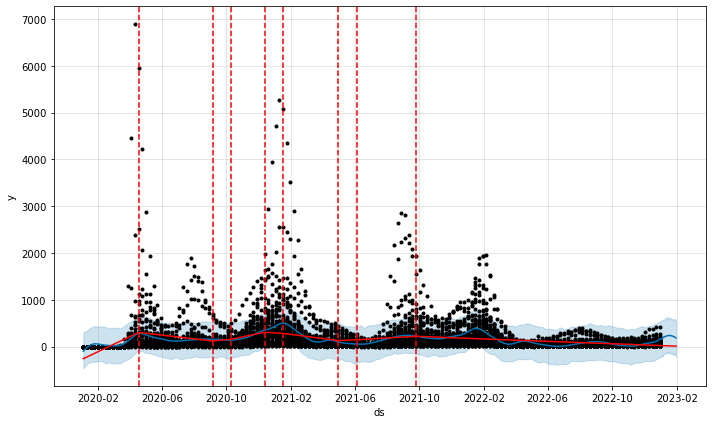

In [191]:
from prophet.plot import add_changepoints_to_plot

# Change points to plot
fig = model_baseline.plot(forecast_baseline)
a = add_changepoints_to_plot(fig.gca(), model_baseline, forecast_baseline)

In [211]:

# Create the prophet model with confidence internal of 95%
model_changepoint = Prophet(interval_width=0.95, n_changepoints=2)
# Fit the model using the training dataset
model_changepoint.fit(train.reset_index().rename(columns={'date':'ds', 'weekly_deaths':'y'}))


23:53:16 - cmdstanpy - INFO - Chain [1] start processing
23:53:17 - cmdstanpy - INFO - Chain [1] done processing


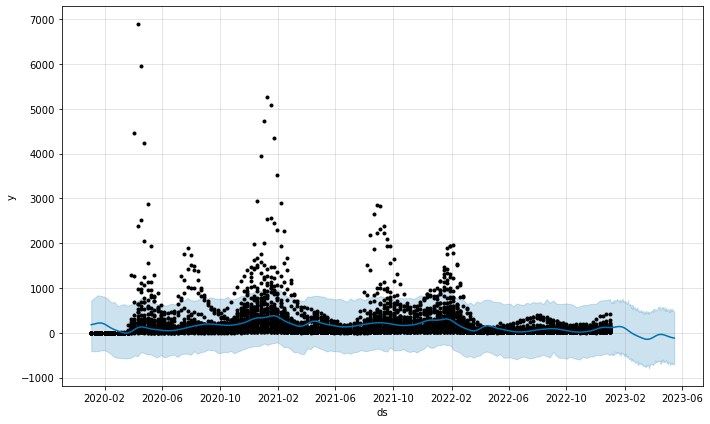

In [212]:
# Create the time range for the forecast
future_changepoint = model_changepoint.make_future_dataframe(periods=136)

# Make prediction
forecast_changepoint = model_changepoint.predict(future_changepoint)

# Visualize the forecast
model_changepoint.plot(forecast_changepoint); # Add semi-colon to remove the duplicated chart

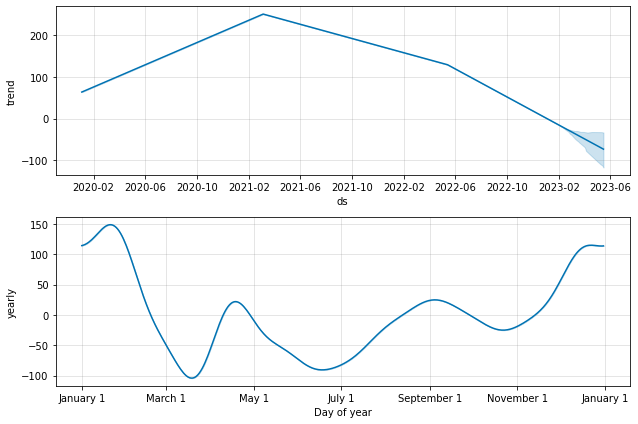

In [213]:
# Visualize the forecast components
model_changepoint.plot_components(forecast_changepoint);

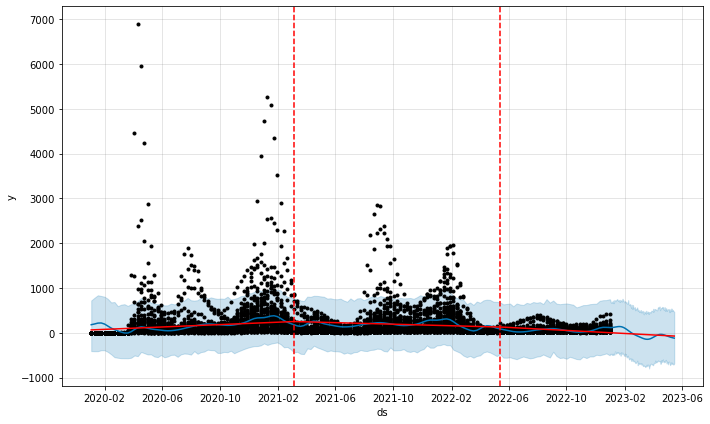

In [214]:
# Change points to plot
fig = model_changepoint.plot(forecast_changepoint)
a = add_changepoints_to_plot(fig.gca(), model_changepoint, forecast_changepoint)

In [215]:
# Merge actual and predicted values
performance_changepoint = pd.merge(test.reset_index().rename(columns={'date':'ds', 'weekly_deaths':'y'}),
                                   forecast_changepoint[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
                                   on='ds')
# Check MAE value
performance_changepoint_MAE = mean_absolute_error(performance_changepoint['y'], performance_changepoint['yhat'])
print(f'The MAE for the baseline model is {performance_changepoint_MAE}')

# Check MAPE value
performance_changepoint_MAPE = mean_absolute_percentage_error(performance_changepoint['y'], performance_changepoint['yhat'])
print(f'The MAPE for the baseline model is {performance_changepoint_MAPE}')

The MAE for the baseline model is 72.9445044934877
The MAPE for the baseline model is 1097720726146035.6


### 3. add seasonality to baseline model

In [216]:
# Add seasonality
model_season = Prophet(yearly_seasonality=True, weekly_seasonality=True, n_changepoints = 2)

# Fit the model on the training dataset
model_season.fit(train.reset_index().rename(columns={'date':'ds', 'weekly_deaths':'y'}))

23:53:38 - cmdstanpy - INFO - Chain [1] start processing
23:53:38 - cmdstanpy - INFO - Chain [1] done processing


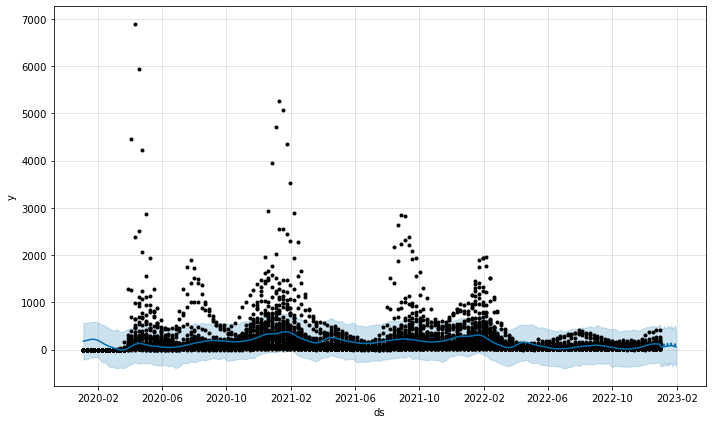

In [217]:
# Create the time range for the forecast
future_season = model_season.make_future_dataframe(periods=30)

# Make prediction
forecast_season = model_season.predict(future_season)

# Visualize the forecast
model_season.plot(forecast_season); # Add semi-colon to remove the duplicated chart

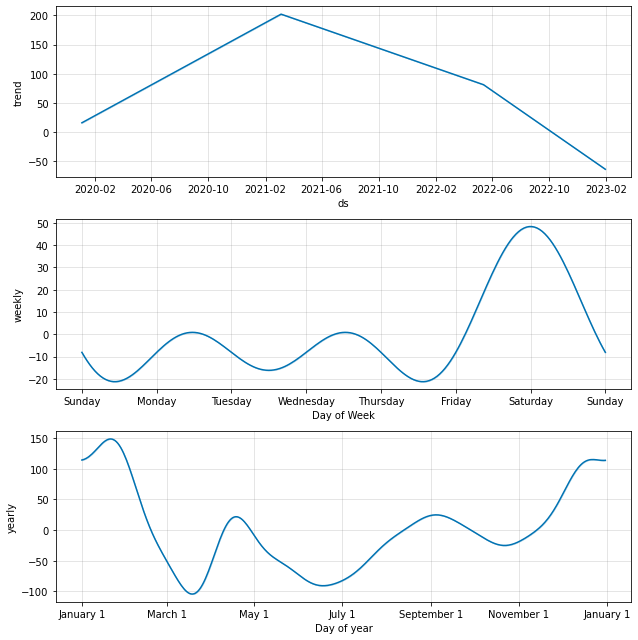

In [218]:
# Visualize the forecast components
model_season.plot_components(forecast_season);

In [219]:
# Merge actual and predicted values
performance_season = pd.merge(test.reset_index().rename(columns={'date':'ds', 'weekly_deaths':'y'}), forecast_season[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-30:], on='ds')

# Check MAE value
performance_season_MAE = mean_absolute_error(performance_season['y'], performance_season['yhat'])
print(f'The MAE for the seasonality model is {performance_season_MAE}')

# Check MAPE value
performance_season_MAPE = mean_absolute_percentage_error(performance_season['y'], performance_season['yhat'])
print(f'The MAPE for the seasonality model is {performance_season_MAPE}')

The MAE for the seasonality model is 77.81456026192987
The MAPE for the seasonality model is 2.634370843267317


### 4. baseline with seasonality and Holiday

In [220]:
# Add holidays
model_holiday = Prophet(yearly_seasonality=True, weekly_seasonality=True, n_changepoints = 2)

# Add built-in country-specific holidays
model_holiday.add_country_holidays(country_name='US')

# Fit the model on the training dataset
model_holiday.fit(train.reset_index().rename(columns={'date':'ds', 'weekly_deaths':'y'}))

# All the holidays and events
model_holiday.train_holiday_names

23:53:46 - cmdstanpy - INFO - Chain [1] start processing
23:53:47 - cmdstanpy - INFO - Chain [1] done processing


0                                      New Year's Day
1                                        Memorial Day
2                                    Independence Day
3                         Independence Day (observed)
4                                           Labor Day
5                                        Veterans Day
6                                        Thanksgiving
7                                       Christmas Day
8                          Martin Luther King Jr. Day
9                               Washington's Birthday
10                                       Columbus Day
11                          New Year's Day (observed)
12               Juneteenth National Independence Day
13    Juneteenth National Independence Day (observed)
14                           Christmas Day (observed)
dtype: object

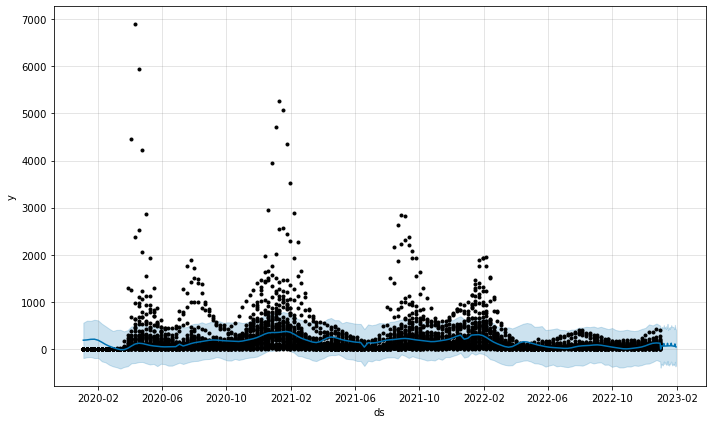

In [221]:
# Create the time range for the forecast
future_holiday = model_holiday.make_future_dataframe(periods=30)

# Make prediction
forecast_holiday = model_holiday.predict(future_holiday)

# Visualize the forecast
model_holiday.plot(forecast_holiday); # Add semi-colon to remove the duplicated chart

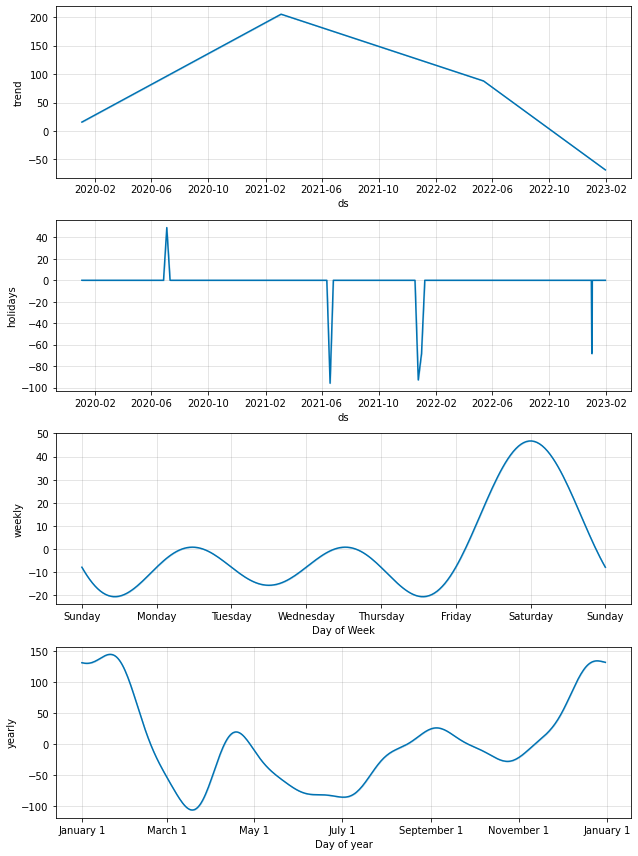

In [222]:
# Visualize the forecast components
model_holiday.plot_components(forecast_holiday);

In [223]:
# Merge actual and predicted values
performance_holiday = pd.merge(test.reset_index().rename(columns={'date':'ds', 'weekly_deaths':'y'}), forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-30:], on='ds')

# Check MAE value
performance_holiday_MAE = mean_absolute_error(performance_holiday['y'], performance_holiday['yhat'])
print(f'The MAE for the holiday/event model is {performance_holiday_MAE}')

# Check MAPE value
performance_holiday_MAPE = mean_absolute_percentage_error(performance_holiday['y'], performance_holiday['yhat'])
print(f'The MAPE for the holiday/event model is {performance_holiday_MAPE}')

The MAE for the holiday/event model is 74.18929125134427
The MAPE for the holiday/event model is 2.495091974131806


# Building Multivariate Model
        
- the basic models I ran w additional regressors
    - these are the models:
        - w all the regressors: MAE of 98
        - add changepoints: 108
        - with the regressors + seasonality: MAE of 98
        - with the regressors + seasonality + holidays: MAE of 113
        - regressors + holidays + changepoints: MAE 112

### model with all the regressors

In [224]:
print(train.shape, test.shape)

(6974, 143) (332, 143)


23:54:07 - cmdstanpy - INFO - Chain [1] start processing
23:54:41 - cmdstanpy - INFO - Chain [1] done processing


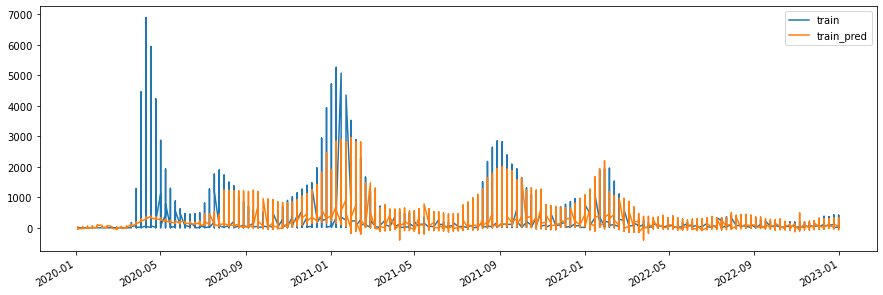

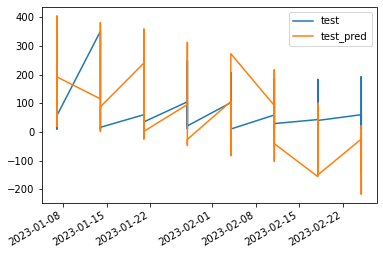

Training Set Metrics:
Training MAE: 173.25615570390914
Training MASE: 1.0079302285002611

Testing Set Metrics:
Testing MAE: 98.5059769913452
Testing MASE: 1.001166493559001


In [226]:
model = Prophet()
for col in train.columns:
    if col not in ['date', 'weekly_deaths']:
        model.add_regressor(col)
model=model.fit(train.reset_index().rename(columns={'date':'ds', 'weekly_deaths':'y'}))

train_pred=model.predict(train.reset_index().rename(columns={'date':'ds', 'weekly_deaths':'y'})).set_index('ds')

pd.concat([train['weekly_deaths'],train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])
plt.show()

test_pred=model.predict(test.reset_index().rename(columns={'date':'ds', 'weekly_deaths':'y'})).set_index('ds')
pd.concat([test['weekly_deaths'],test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate metrics

# Train

train_mae = mean_absolute_error(train['weekly_deaths'], train_pred['yhat'])
train_mase = MASE(train['weekly_deaths'], train_pred['yhat'])

print("Training Set Metrics:")
print("Training MAE:", train_mae)
print("Training MASE:", train_mase)


test_mae = mean_absolute_error(test['weekly_deaths'], test_pred['yhat'])
test_mase = MASE(test['weekly_deaths'], test_pred['yhat'])

print("\nTesting Set Metrics:")
print("Testing MAE:", test_mae)
print("Testing MASE:", test_mase)

### add changepoints

23:54:59 - cmdstanpy - INFO - Chain [1] start processing
23:55:32 - cmdstanpy - INFO - Chain [1] done processing


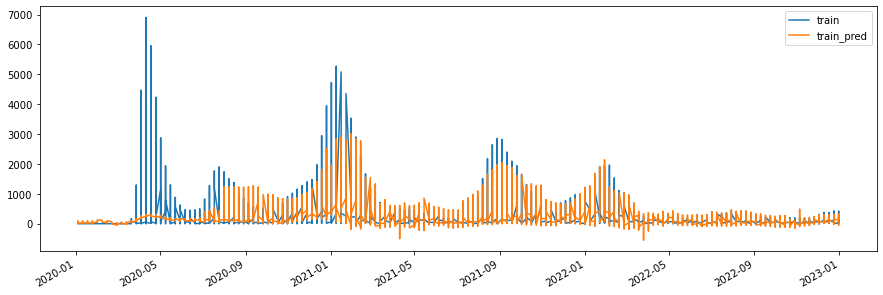

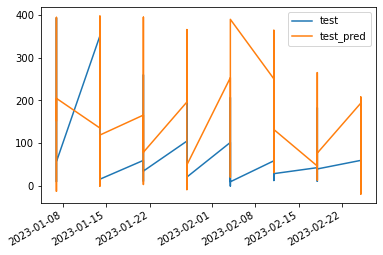

Training Set Metrics:
Training MAE: 176.32111697136443
Training MASE: 1.0095224123763828

Testing Set Metrics:
Testing MAE: 108.43812546745684
Testing MASE: 1.0125475236766175


In [227]:
model = Prophet(n_changepoints = 2)
for col in train.columns:
    if col not in ['date', 'weekly_deaths']:
        model.add_regressor(col)
model=model.fit(train.reset_index().rename(columns={'date':'ds', 'weekly_deaths':'y'}))

train_pred=model.predict(train.reset_index().rename(columns={'date':'ds', 'weekly_deaths':'y'})).set_index('ds')

pd.concat([train['weekly_deaths'],train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])
plt.show()

test_pred=model.predict(test.reset_index().rename(columns={'date':'ds', 'weekly_deaths':'y'})).set_index('ds')
pd.concat([test['weekly_deaths'],test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate metrics

# Train

train_mae = mean_absolute_error(train['weekly_deaths'], train_pred['yhat'])
train_mase = MASE(train['weekly_deaths'], train_pred['yhat'])

print("Training Set Metrics:")
print("Training MAE:", train_mae)
print("Training MASE:", train_mase)


test_mae = mean_absolute_error(test['weekly_deaths'], test_pred['yhat'])
test_mase = MASE(test['weekly_deaths'], test_pred['yhat'])

print("\nTesting Set Metrics:")
print("Testing MAE:", test_mae)
print("Testing MASE:", test_mase)

In [228]:
df = train.rename_axis('ds').reset_index()

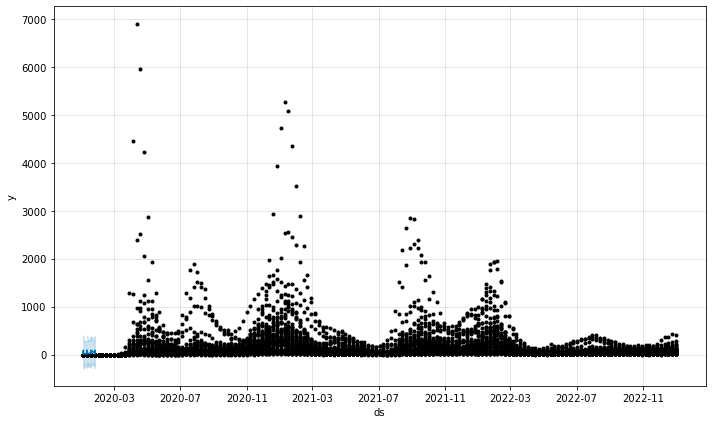

In [231]:
# Create the future dataframe with the same regressors
future = model.make_future_dataframe(periods=30)
for col in df.columns:
    if col not in ['date', 'weekly_deaths']:
        future[col] = df[col]

# Make prediction
forecast = model.predict(future)

# Visualize the forecast
fig = model.plot(forecast)

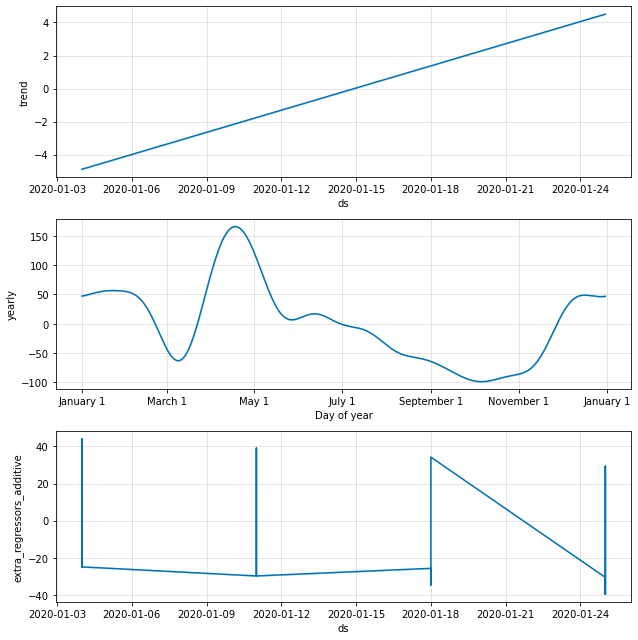

In [232]:
# Visualize the forecast components
model.plot_components(forecast);

### Add holidays and seasonality to model with all the regressors
- makes mae WORSE

In [310]:
model = Prophet(n_changepoints = 2)
for col in train.columns:
    if col not in ['date', 'weekly_deaths']:
        model.add_regressor(col)
        
model.add_country_holidays(country_name='US')
model=model.fit(train.reset_index().rename(columns={'date':'ds', 'weekly_deaths':'y'}))

00:52:09 - cmdstanpy - INFO - Chain [1] start processing
00:52:42 - cmdstanpy - INFO - Chain [1] done processing


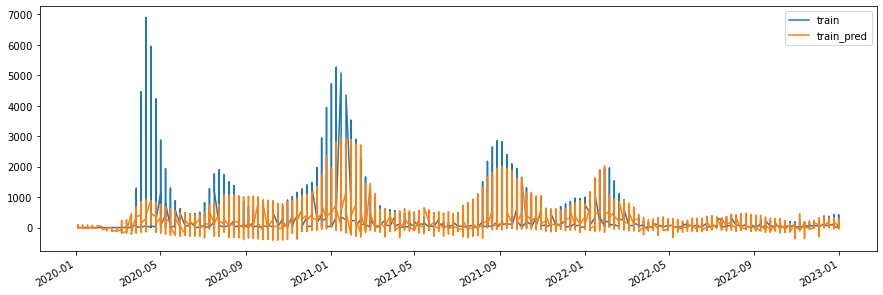

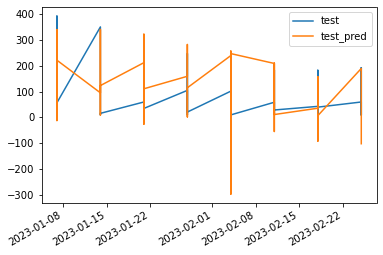

Training Set Metrics:
Training MAE: 196.1671996020592
Training MASE: 0.021883704705367813

Testing Set Metrics:
Testing MAE: 91.07126075611461
Testing MASE: 0.024016580777013533


In [311]:
train_pred=model.predict(train.reset_index().rename(columns={'date':'ds', 'weekly_deaths':'y'})).set_index('ds')
pd.concat([train['weekly_deaths'],train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])
plt.show()

test_pred=model.predict(test.reset_index().rename(columns={'date':'ds', 'weekly_deaths':'y'})).set_index('ds')
pd.concat([test['weekly_deaths'],test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate metrics

# Train

train_mae = mean_absolute_error(train['weekly_deaths'], train_pred['yhat'])
train_mase = MASE(train['weekly_deaths'], train_pred['yhat'])

print("Training Set Metrics:")
print("Training MAE:", train_mae)
print("Training MASE:", train_mase)


test_mae = mean_absolute_error(test['weekly_deaths'], test_pred['yhat'])
test_mase = MASE(test['weekly_deaths'], test_pred['yhat'])

print("\nTesting Set Metrics:")
print("Testing MAE:", test_mae)
print("Testing MASE:", test_mase)

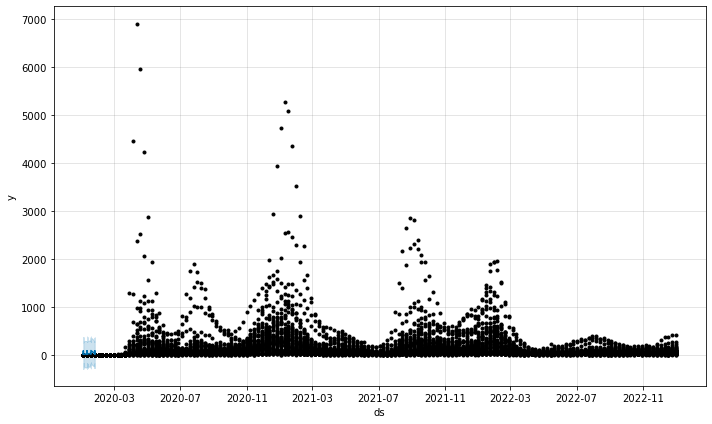

In [237]:
# Create the future dataframe with the same regressors
future = model.make_future_dataframe(periods=30)
for col in df.columns:
    if col not in ['date', 'weekly_deaths']:
        future[col] = df[col]

# Make prediction
forecast = model.predict(future)

# Visualize the forecast
model.plot(forecast);

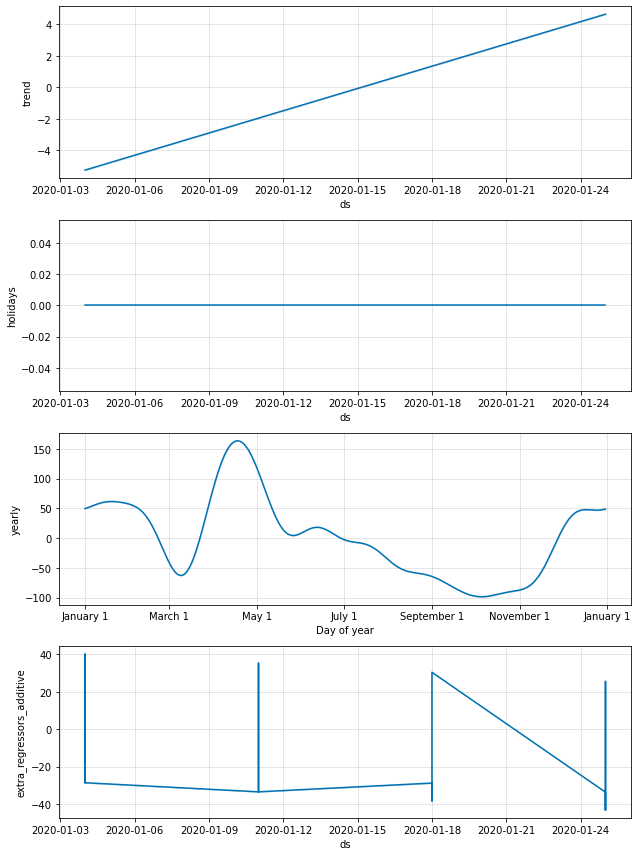

In [238]:
# Visualize the forecast components
model.plot_components(forecast);

# Multivariate

### With a log transformation
- this is what we will be doing cross validation on

In [ ]:
## for metric testing
df = train.rename_axis('ds').reset_index()

In [239]:
# Log-transform 'weekly_deaths' in both train and test datasets
train['log_weekly_deaths'] = np.log1p(train['weekly_deaths'])
test['log_weekly_deaths'] = np.log1p(test['weekly_deaths'])

00:51:08 - cmdstanpy - INFO - Chain [1] start processing
00:51:47 - cmdstanpy - INFO - Chain [1] done processing


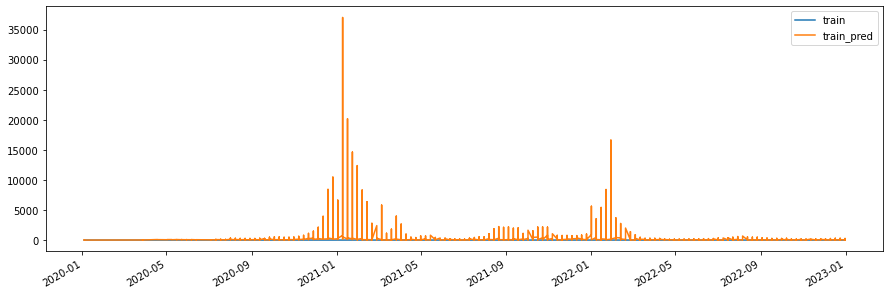

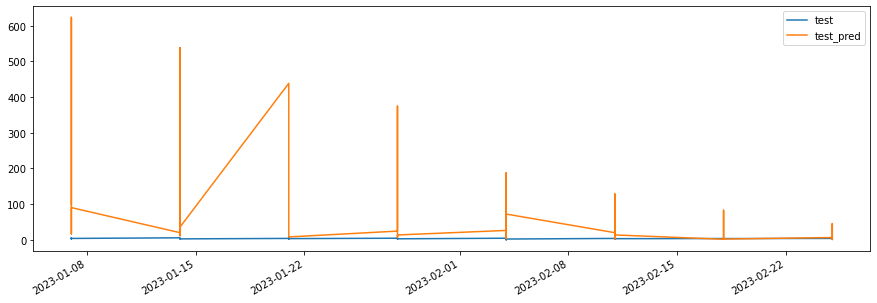

Training Set Metrics:
Training MAE: 183.9670407674638
Training MASE: 0.021446093949325395

Testing Set Metrics:
Testing MAE: 63.33720992052484
Testing MASE: 0.024501555669616724


In [308]:
# Create and fit the Prophet model with log-transformed target variable
model = Prophet()
for col in train.columns:
    if col not in ['date', 'weekly_deaths', 'log_weekly_deaths']:
        model.add_regressor(col)

model = model.fit(train.reset_index().rename(columns={'date': 'ds', 'log_weekly_deaths': 'y'}))

# Make predictions on the training set
train_pred = model.predict(train.reset_index().rename(columns={'date': 'ds', 'log_weekly_deaths': 'y'})).set_index('ds')

# Apply inverse log transformation to get predictions in the original scale
train_pred['yhat'] = np.expm1(train_pred['yhat'])

# Plot the training set predictions
pd.concat([train['log_weekly_deaths'], train_pred['yhat']], axis=1).plot(figsize=(15, 5))
plt.legend(['train', 'train_pred'])
plt.show()

# Make predictions on the test set
test_pred = model.predict(test.reset_index().rename(columns={'date': 'ds', 'log_weekly_deaths': 'y'})).set_index('ds')

# Apply inverse log transformation to get predictions in the original scale
test_pred['yhat'] = np.expm1(test_pred['yhat'])

# Plot the test set predictions
pd.concat([test['log_weekly_deaths'], test_pred['yhat']], axis=1).plot(figsize=(15, 5))
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate metrics

# Train
train_mae = mean_absolute_error(train['weekly_deaths'], train_pred['yhat'])
train_mase = MASE(train['weekly_deaths'], train_pred['yhat'])

print("Training Set Metrics:")
print("Training MAE:", train_mae)
print("Training MASE:", train_mase)

# Test
test_mae = mean_absolute_error(test['weekly_deaths'], test_pred['yhat'])
test_mase = MASE(test['weekly_deaths'], test_pred['yhat'])

print("\nTesting Set Metrics:")
print("Testing MAE:", test_mae)
print("Testing MASE:", test_mase)


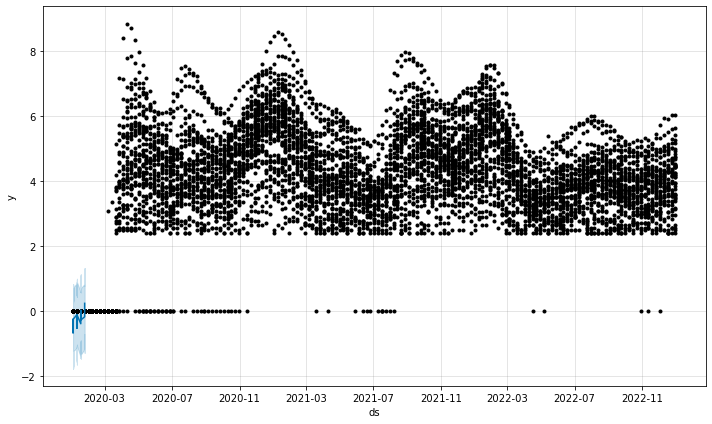

In [241]:
# Create the future dataframe with the same regressors
future = model.make_future_dataframe(periods=30)
for col in df.columns:
    if col not in ['date', 'weekly_deaths', 'log_weekly_deaths']:
        future[col] = df[col]

# Make prediction
forecast = model.predict(future)

# Visualize the forecast
model.plot(forecast);

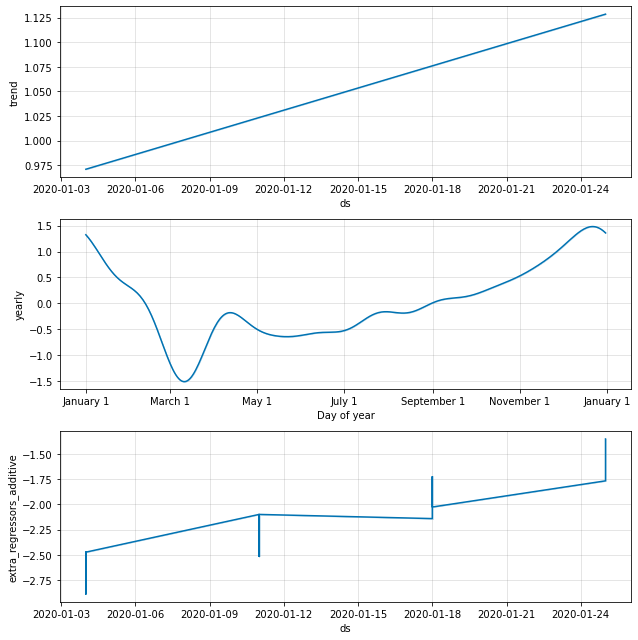

In [242]:
# Visualize the forecast components
model.plot_components(forecast);

### adding seasonality and holidays

00:50:25 - cmdstanpy - INFO - Chain [1] start processing
00:50:55 - cmdstanpy - INFO - Chain [1] done processing


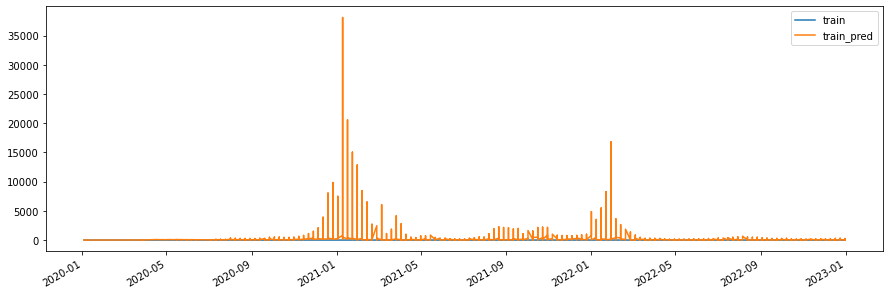

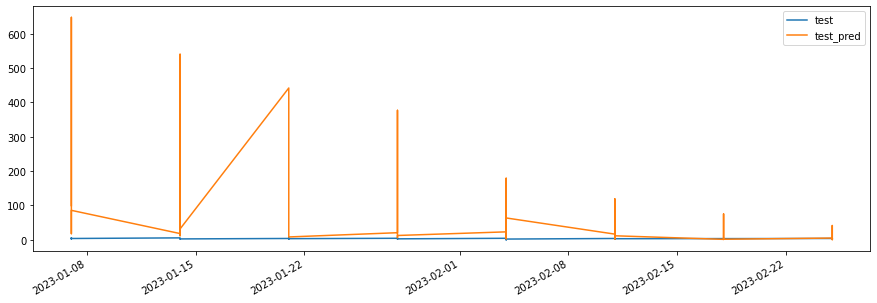

Training Set Metrics:
Training MAE: 184.47252054430052
Training MASE: 0.021445489759689528

Testing Set Metrics:
Testing MAE: 63.54094876627705
Testing MASE: 0.024540180990736463


In [307]:
# Create and fit the Prophet model with log-transformed target variable
model = Prophet(yearly_seasonality = True, weekly_seasonality = True)
for col in train.columns:
    if col not in ['date', 'weekly_deaths', 'log_weekly_deaths']:
        model.add_regressor(col)
model.add_country_holidays(country_name='US')
model = model.fit(train.reset_index().rename(columns={'date': 'ds', 'log_weekly_deaths': 'y'}))

# Make predictions on the training set
train_pred = model.predict(train.reset_index().rename(columns={'date': 'ds', 'log_weekly_deaths': 'y'})).set_index('ds')

# Apply inverse log transformation to get predictions in the original scale
train_pred['yhat'] = np.expm1(train_pred['yhat'])

# Plot the training set predictions
pd.concat([train['log_weekly_deaths'], train_pred['yhat']], axis=1).plot(figsize=(15, 5))
plt.legend(['train', 'train_pred'])
plt.show()

# Make predictions on the test set
test_pred = model.predict(test.reset_index().rename(columns={'date': 'ds', 'log_weekly_deaths': 'y'})).set_index('ds')

# Apply inverse log transformation to get predictions in the original scale
test_pred['yhat'] = np.expm1(test_pred['yhat'])

# Plot the test set predictions
pd.concat([test['log_weekly_deaths'], test_pred['yhat']], axis=1).plot(figsize=(15, 5))
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate metrics

# Train
train_mae = mean_absolute_error(train['weekly_deaths'], train_pred['yhat'])
train_mase = MASE(train['weekly_deaths'], train_pred['yhat'])

print("Training Set Metrics:")
print("Training MAE:", train_mae)
print("Training MASE:", train_mase)

# Test
test_mae = mean_absolute_error(test['weekly_deaths'], test_pred['yhat'])
test_mase = MASE(test['weekly_deaths'], test_pred['yhat'])

print("\nTesting Set Metrics:")
print("Testing MAE:", test_mae)
print("Testing MASE:", test_mase)

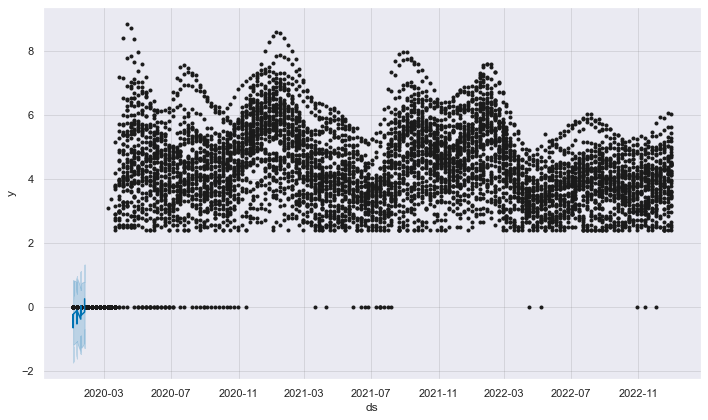

In [236]:
# Create the future dataframe with the same regressors
future = model.make_future_dataframe(periods=30)
for col in df.columns:
    if col not in ['date', 'weekly_deaths', 'log_weekly_deaths']:
        future[col] = df[col]

# Make prediction
forecast = model.predict(future)

# Visualize the forecast
model.plot(forecast);

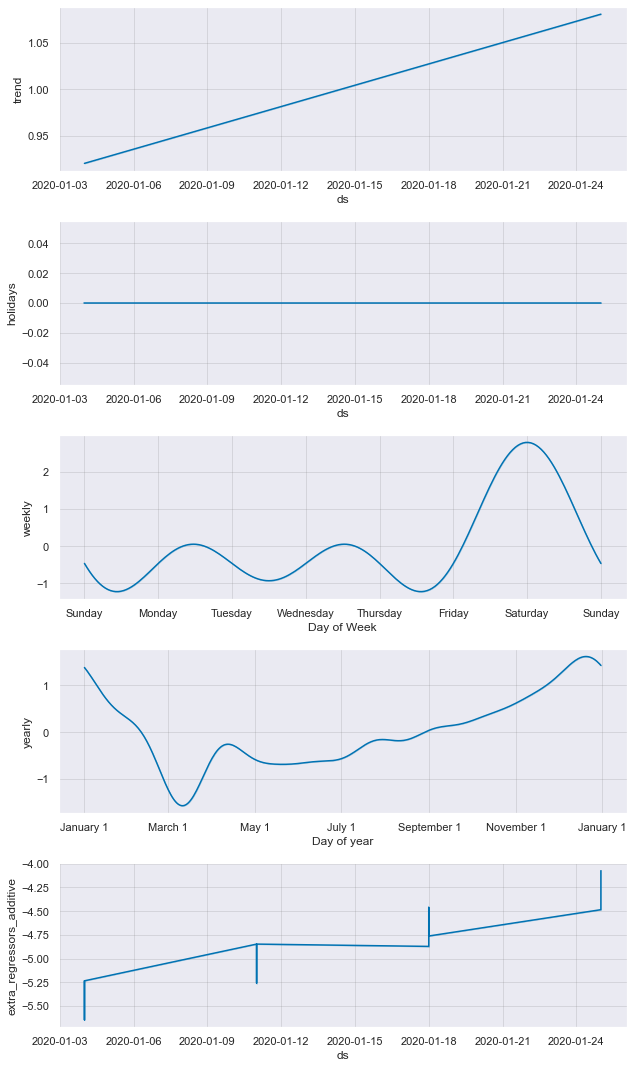

In [237]:
# Visualize the forecast components
model.plot_components(forecast);

# Cross Validation
- done on the first log one

In [94]:
from prophet.diagnostics import cross_validation
# Cross validation
data_cv = cross_validation(model_holiday, initial='730 days', period='30 days', horizon = '30 days', parallel="processes")
data_cv.head()

18:47:11 - cmdstanpy - INFO - Chain [1] start processing
18:47:11 - cmdstanpy - INFO - Chain [1] start processing
18:47:11 - cmdstanpy - INFO - Chain [1] start processing
18:47:11 - cmdstanpy - INFO - Chain [1] start processing
18:47:11 - cmdstanpy - INFO - Chain [1] start processing
18:47:11 - cmdstanpy - INFO - Chain [1] start processing
18:47:12 - cmdstanpy - INFO - Chain [1] start processing
18:47:12 - cmdstanpy - INFO - Chain [1] start processing
18:47:12 - cmdstanpy - INFO - Chain [1] done processing
18:47:12 - cmdstanpy - INFO - Chain [1] done processing
18:47:12 - cmdstanpy - INFO - Chain [1] done processing
18:47:12 - cmdstanpy - INFO - Chain [1] done processing
18:47:12 - cmdstanpy - INFO - Chain [1] done processing
18:47:12 - cmdstanpy - INFO - Chain [1] done processing
18:47:12 - cmdstanpy - INFO - Chain [1] done processing
18:47:12 - cmdstanpy - INFO - Chain [1] done processing
18:47:13 - cmdstanpy - INFO - Chain [1] start processing
18:47:13 - cmdstanpy - INFO - Chain [1]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2022-01-08,309.469867,-114.109562,740.185247,659.0,2022-01-05
1,2022-01-08,309.469867,-139.442369,729.270031,360.0,2022-01-05
2,2022-01-08,309.469867,-140.613784,735.072372,1151.0,2022-01-05
3,2022-01-08,309.469867,-122.047756,787.966596,56.0,2022-01-05
4,2022-01-08,309.469867,-156.373974,732.579431,74.0,2022-01-05


In [95]:
from prophet.diagnostics import performance_metrics

# Model performance metrics
data_p = performance_metrics(data_cv)
data_p.head()

,horizon,mse,rmse,mae,mdape,smape,coverage
0,3 days,45868.769734,214.169955,130.783350,1.009166,0.876381,0.958847
1,4 days,31322.218662,176.980843,121.957966,0.950967,0.923050,0.972851
2,5 days,31304.289616,176.930183,117.429126,0.808996,0.978201,0.972851
3,6 days,14779.361805,121.570399,83.053793,0.791642,0.938736,0.995329
4,7 days,9247.465454,96.163743,65.994624,0.780067,0.923222,1.000000


### hyperparameter tuning on season model using cross validation

In [99]:
import itertools
import numpy as np
import pandas as pd

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative'],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = []  # Store the MAEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train.reset_index().rename(columns={'date': 'ds', 'log_weekly_deaths': 'y'}))  # Fit model with given params
    df_cv = cross_validation(m, initial='730 days', period='60 days', horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, metrics=['mae'], rolling_window=1)
    maes.extend(df_p['mae'].tolist())  # Use extend instead of append

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes
print(tuning_results)


22:26:52 - cmdstanpy - INFO - Chain [1] start processing
22:26:52 - cmdstanpy - INFO - Chain [1] done processing
22:26:59 - cmdstanpy - INFO - Chain [1] start processing
22:26:59 - cmdstanpy - INFO - Chain [1] start processing
22:26:59 - cmdstanpy - INFO - Chain [1] start processing
22:26:59 - cmdstanpy - INFO - Chain [1] start processing
22:26:59 - cmdstanpy - INFO - Chain [1] start processing
22:27:00 - cmdstanpy - INFO - Chain [1] start processing
22:27:00 - cmdstanpy - INFO - Chain [1] done processing
22:27:00 - cmdstanpy - INFO - Chain [1] done processing
22:27:00 - cmdstanpy - INFO - Chain [1] done processing
22:27:01 - cmdstanpy - INFO - Chain [1] done processing
22:27:01 - cmdstanpy - INFO - Chain [1] done processing
22:27:01 - cmdstanpy - INFO - Chain [1] done processing
22:27:02 - cmdstanpy - INFO - Chain [1] start processing
22:27:03 - cmdstanpy - INFO - Chain [1] done processing
22:27:09 - cmdstanpy - INFO - Chain [1] start processing
22:27:09 - cmdstanpy - INFO - Chain [1]

     changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                      0.001                     0.01                  0.01   
1                      0.001                     0.01                  0.01   
2                      0.001                     0.01                  0.10   
3                      0.001                     0.01                  0.10   
4                      0.001                     0.01                  1.00   
..                       ...                      ...                   ...   
123                    0.500                    10.00                  0.10   
124                    0.500                    10.00                  1.00   
125                    0.500                    10.00                  1.00   
126                    0.500                    10.00                 10.00   
127                    0.500                    10.00                 10.00   

    seasonality_mode       mae  
0           additi

In [100]:
best_params = all_params[np.argmin(maes)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


In [101]:
tuning_results.loc[tuning_results['mae'].idxmin()]

changepoint_prior_scale         0.5
seasonality_prior_scale         0.1
holidays_prior_scale           0.01
seasonality_mode           additive
mae                        0.748363
Name: 104, dtype: object

# Retrain the season model using the best parameters

### using the first log model - 63.3 MAE

In [261]:
model_tuned = Prophet(changepoint_prior_scale=0.5, seasonality_prior_scale=0.01 )

# Fit the model on the training dataset
model_tuned.fit(train.reset_index().rename(columns={'date': 'ds', 'log_weekly_deaths': 'y'}))

00:13:01 - cmdstanpy - INFO - Chain [1] start processing
00:13:03 - cmdstanpy - INFO - Chain [1] done processing


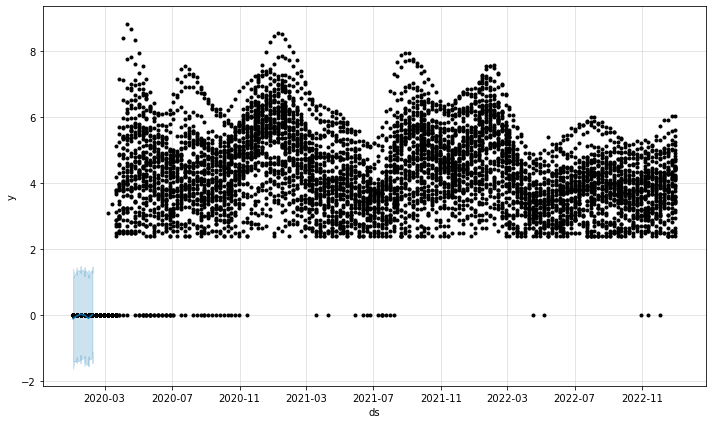

In [275]:
# Create the future dataframe with the same regressors
future_tuned = model_tuned.make_future_dataframe(periods=136)
for col in df.columns:
    if col not in ['date', 'weekly_deaths', 'log_weekly_deaths']:
        future_tuned[col] = df[col]

# Make prediction
forecast_tuned = model_tuned.predict(future_tuned)

# Visualize the forecast
model.plot(forecast_tuned);

In [283]:
optimal_params = {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}

00:49:28 - cmdstanpy - INFO - Chain [1] start processing
00:50:02 - cmdstanpy - INFO - Chain [1] done processing


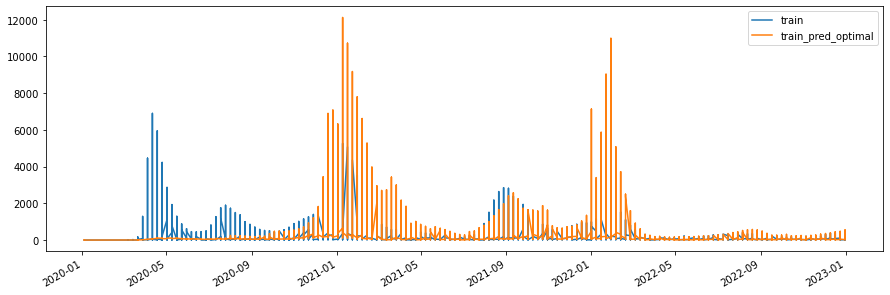

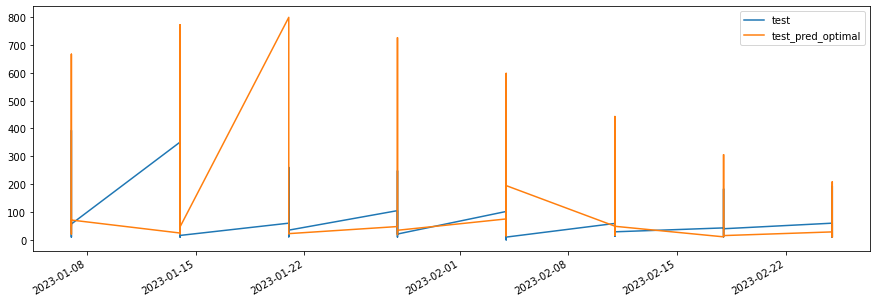

Training Set Metrics (Optimal Model):
Training MAE: 170.85537251504232
Training MASE: 0.021564255344835914

Testing Set Metrics (Optimal Model):
Testing MAE: 70.45431515484418
Testing MASE: 0.02416753242143633


In [306]:
# Create and fit the Prophet model with optimal parameters
model_optimal = Prophet(
    changepoint_prior_scale=optimal_params['changepoint_prior_scale'],
    seasonality_prior_scale=optimal_params['seasonality_prior_scale'],
    holidays_prior_scale=optimal_params['holidays_prior_scale'],
    seasonality_mode=optimal_params['seasonality_mode'],
    yearly_seasonality=True,
    weekly_seasonality=True
)

# Add regressors
for col in train.columns:
    if col not in ['date', 'weekly_deaths', 'log_weekly_deaths']:
        model_optimal.add_regressor(col)

# Fit the model on the training dataset
model_optimal = model_optimal.fit(train.reset_index().rename(columns={'date': 'ds', 'log_weekly_deaths': 'y'}))

# Make predictions on the training set
train_pred_optimal = model_optimal.predict(train.reset_index().rename(columns={'date': 'ds', 'log_weekly_deaths': 'y'})).set_index('ds')

# Apply inverse log transformation to get predictions in the original scale
train_pred_optimal['yhat'] = np.expm1(train_pred_optimal['yhat'])

# Plot the training set predictions
pd.concat([train['weekly_deaths'], train_pred_optimal['yhat']], axis=1).plot(figsize=(15, 5))
plt.legend(['train', 'train_pred_optimal'])
plt.show()

# Make predictions on the test set
test_pred_optimal = model_optimal.predict(test.reset_index().rename(columns={'date': 'ds', 'log_weekly_deaths': 'y'})).set_index('ds')

# Apply inverse log transformation to get predictions in the original scale
test_pred_optimal['yhat'] = np.expm1(test_pred_optimal['yhat'])

# Plot the test set predictions
pd.concat([test['weekly_deaths'], test_pred_optimal['yhat']], axis=1).plot(figsize=(15, 5))
plt.legend(['test', 'test_pred_optimal'])
plt.show()

# Calculate metrics for the optimal model
train_mae_optimal = mean_absolute_error(train['weekly_deaths'], train_pred_optimal['yhat'])
train_mase_optimal = MASE(train['weekly_deaths'], train_pred_optimal['yhat'])

print("Training Set Metrics (Optimal Model):")
print("Training MAE:", train_mae_optimal)
print("Training MASE:", train_mase_optimal)

test_mae_optimal = mean_absolute_error(test['weekly_deaths'], test_pred_optimal['yhat'])
test_mase_optimal = MASE(test['weekly_deaths'], test_pred_optimal['yhat'])

print("\nTesting Set Metrics (Optimal Model):")
print("Testing MAE:", test_mae_optimal)
print("Testing MASE:", test_mase_optimal)


In [289]:
# Default change points
dff2 = train.reset_index().rename(columns={'date':'ds', 'log_weekly_deaths':'y'})
print(f'There are {len(model_optimal.changepoints)} change points. \nThe change points dates are \n{dff2.loc[dff2["ds"].isin(model_optimal.changepoints)]}')

There are 25 change points. 
The change points dates are 
             ds  year  mmwr_week  weekly_deaths  distributed  \
198  2020-02-01  2020          5            0.0          0.0   
199  2020-02-01  2020          5            0.0          0.0   
200  2020-02-01  2020          5            0.0          0.0   
201  2020-02-01  2020          5            0.0          0.0   
202  2020-02-01  2020          5            0.0          0.0   
...         ...   ...        ...            ...          ...   
5595 2022-05-14  2022         19           15.0    8310750.0   
5596 2022-05-14  2022         19           10.0    6000410.0   
5597 2022-05-14  2022         19           34.0   13562480.0   
5598 2022-05-14  2022         19           60.0   17136710.0   
5599 2022-05-14  2022         19           24.0   11737705.0   

      distributed_janssen  distributed_moderna  distributed_pfizer  \
198                   0.0                  0.0                 0.0   
199                   0.0        

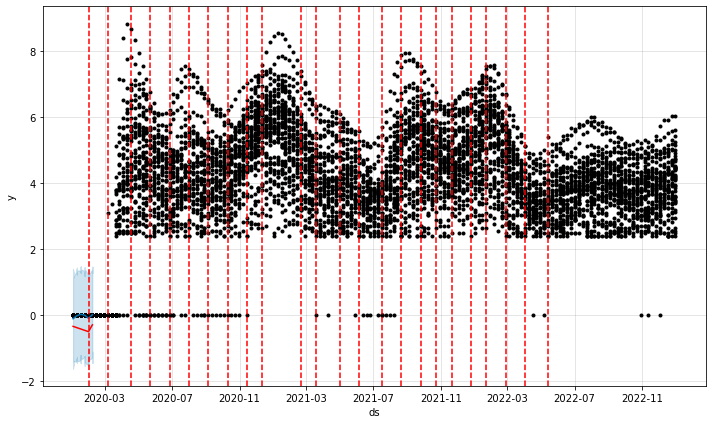

In [290]:
from prophet.plot import add_changepoints_to_plot

# Change points to plot
fig = model_optimal.plot(forecast_tuned)
a = add_changepoints_to_plot(fig.gca(), model_optimal, forecast_tuned)

In [292]:
# Create the prophet model with confidence internal of 95%
model_changepoint_optimal = Prophet(interval_width=0.95, n_changepoints=1)
# Fit the model using the training dataset
model_changepoint_optimal.fit(train.reset_index().rename(columns={'date':'ds', 'log_weekly_deaths':'y'}))


00:34:19 - cmdstanpy - INFO - Chain [1] start processing
00:34:20 - cmdstanpy - INFO - Chain [1] done processing


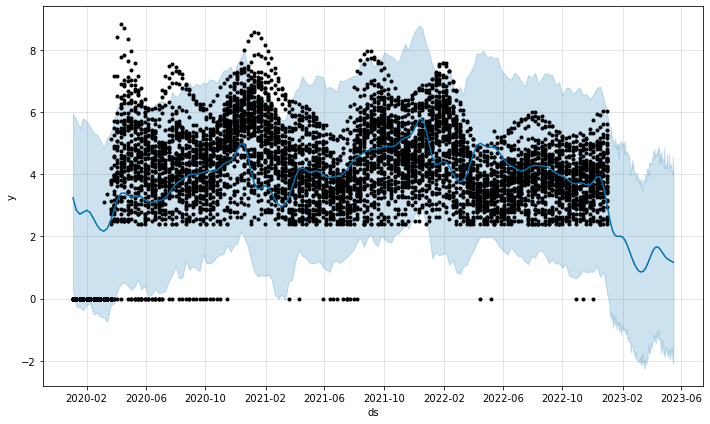

In [293]:
# Create the time range for the forecast
future_changepoint_optimal = model_changepoint_optimal.make_future_dataframe(periods=136)

# Make prediction
forecast_changepoint_optimal = model_changepoint_optimal.predict(future_changepoint_optimal)

# Visualize the forecast
model_changepoint_optimal.plot(forecast_changepoint_optimal); # Add semi-colon to remove the duplicated chart

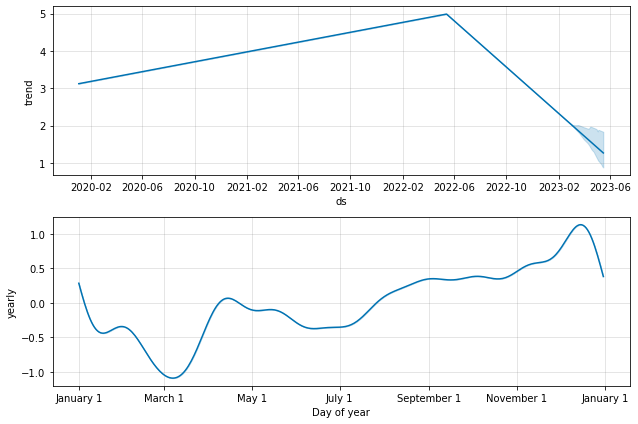

In [294]:
# Visualize the forecast components
model_changepoint_optimal.plot_components(forecast_changepoint_optimal);

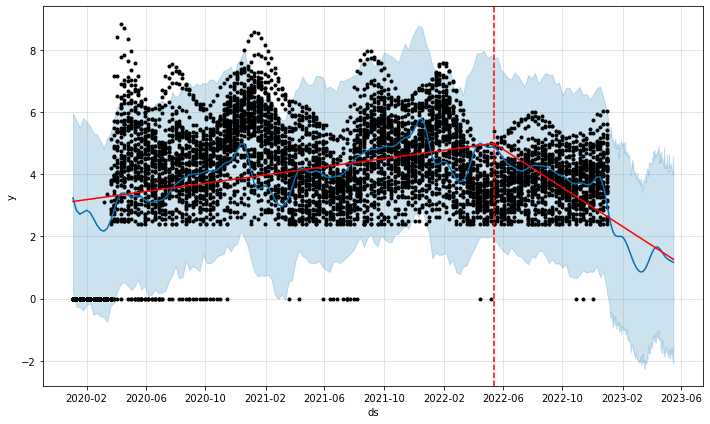

In [295]:
# Change points to plot
fig = model_changepoint_optimal.plot(forecast_changepoint_optimal)
a = add_changepoints_to_plot(fig.gca(), model_changepoint_optimal, forecast_changepoint_optimal)

In [297]:
# Merge actual and predicted values
performance_changepoint_optimal = pd.merge(test.reset_index().rename(columns={'date':'ds', 'log_weekly_deaths':'y'}),
                                   forecast_changepoint_optimal[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
                                   on='ds')
# Check MAE value

performance_changepoint_MAE_log = mean_absolute_error(performance_changepoint_optimal['y'], performance_changepoint_optimal['yhat'])
performance_changepoint_MAE_original = np.expm1(performance_changepoint_MAE_log)
print(f'The MAE for the optimal model in the original scale is {performance_changepoint_MAE_original}')

The MAE for the optimal model in the original scale is 6.67476216942999
The MAPE for the baseline model is 26099835539917.77


# FINAL MODEL
- optimal parameters from cross validation
- optimal number of changepoints found from the optimal model

Testing Set Metrics (Optimal Model):

Testing MAE: 58.70519225241153

Testing MASE: 0.024117998826839526

In [ ]:
## for metric testing
df = train.rename_axis('ds').reset_index()

00:48:31 - cmdstanpy - INFO - Chain [1] start processing
00:48:34 - cmdstanpy - INFO - Chain [1] done processing


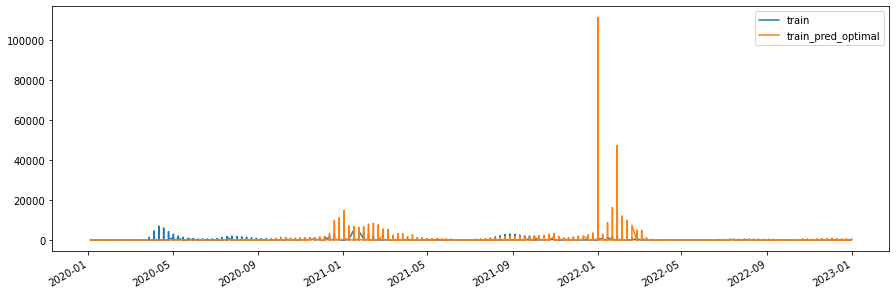

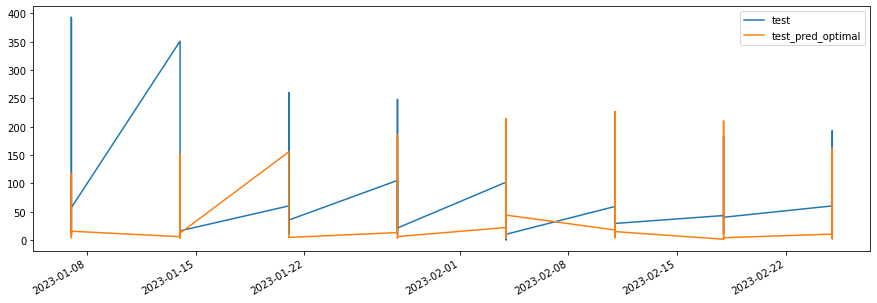

Training Set Metrics (Optimal Model):
Training MAE: 210.60337085801277
Training MASE: 0.0212888308231588

Testing Set Metrics (Optimal Model):
Testing MAE: 58.70519225241153
Testing MASE: 0.024117998826839526


In [305]:
# Create and fit the Prophet model with optimal parameters
model_optimal = Prophet(
    changepoint_prior_scale=optimal_params['changepoint_prior_scale'],
    seasonality_prior_scale=optimal_params['seasonality_prior_scale'],
    holidays_prior_scale=optimal_params['holidays_prior_scale'],
    seasonality_mode=optimal_params['seasonality_mode'],
    yearly_seasonality=True,
    weekly_seasonality=True,
    n_changepoints = 1
)

# Add regressors
for col in train.columns:
    if col not in ['date', 'weekly_deaths', 'log_weekly_deaths']:
        model_optimal.add_regressor(col)

# Fit the model on the training dataset
model_optimal = model_optimal.fit(train.reset_index().rename(columns={'date': 'ds', 'log_weekly_deaths': 'y'}))

# Make predictions on the training set
train_pred_optimal = model_optimal.predict(train.reset_index().rename(columns={'date': 'ds', 'log_weekly_deaths': 'y'})).set_index('ds')

# Apply inverse log transformation to get predictions in the original scale
train_pred_optimal['yhat'] = np.expm1(train_pred_optimal['yhat'])

# Plot the training set predictions
pd.concat([train['weekly_deaths'], train_pred_optimal['yhat']], axis=1).plot(figsize=(15, 5))
plt.legend(['train', 'train_pred_optimal'])
plt.show()

# Make predictions on the test set
test_pred_optimal = model_optimal.predict(test.reset_index().rename(columns={'date': 'ds', 'log_weekly_deaths': 'y'})).set_index('ds')

# Apply inverse log transformation to get predictions in the original scale
test_pred_optimal['yhat'] = np.expm1(test_pred_optimal['yhat'])

# Plot the test set predictions
pd.concat([test['weekly_deaths'], test_pred_optimal['yhat']], axis=1).plot(figsize=(15, 5))
plt.legend(['test', 'test_pred_optimal'])
plt.show()

# Calculate metrics for the optimal model
train_mae_optimal = mean_absolute_error(train['weekly_deaths'], train_pred_optimal['yhat'])
train_mase_optimal = MASE(train['weekly_deaths'], train_pred_optimal['yhat'])

print("Training Set Metrics (Optimal Model):")
print("Training MAE:", train_mae_optimal)
print("Training MASE:", train_mase_optimal)

test_mae_optimal = mean_absolute_error(test['weekly_deaths'], test_pred_optimal['yhat'])
test_mase_optimal = MASE(test['weekly_deaths'], test_pred_optimal['yhat'])

print("\nTesting Set Metrics (Optimal Model):")
print("Testing MAE:", test_mae_optimal)
print("Testing MASE:", test_mase_optimal)

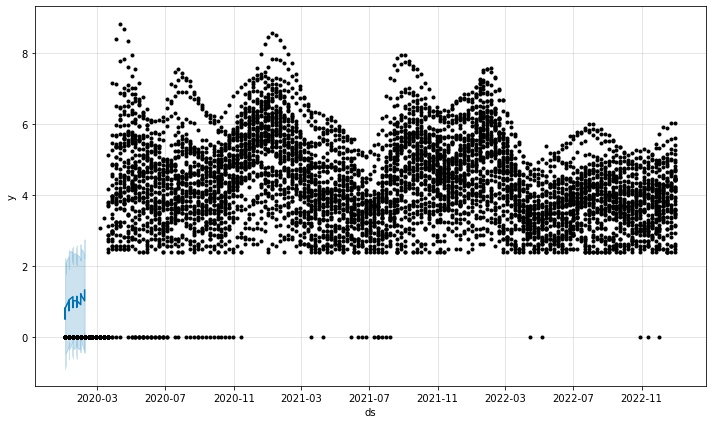

In [302]:
# Create the future dataframe with the same regressors
future_optimal = model_optimal.make_future_dataframe(periods=136)
for col in df.columns:
    if col not in ['date', 'weekly_deaths', 'log_weekly_deaths']:
        future_optimal[col] = df[col]

# Make prediction
forecast_optimal = model_optimal.predict(future_optimal)

# Visualize the forecast
model_optimal.plot(forecast_optimal);

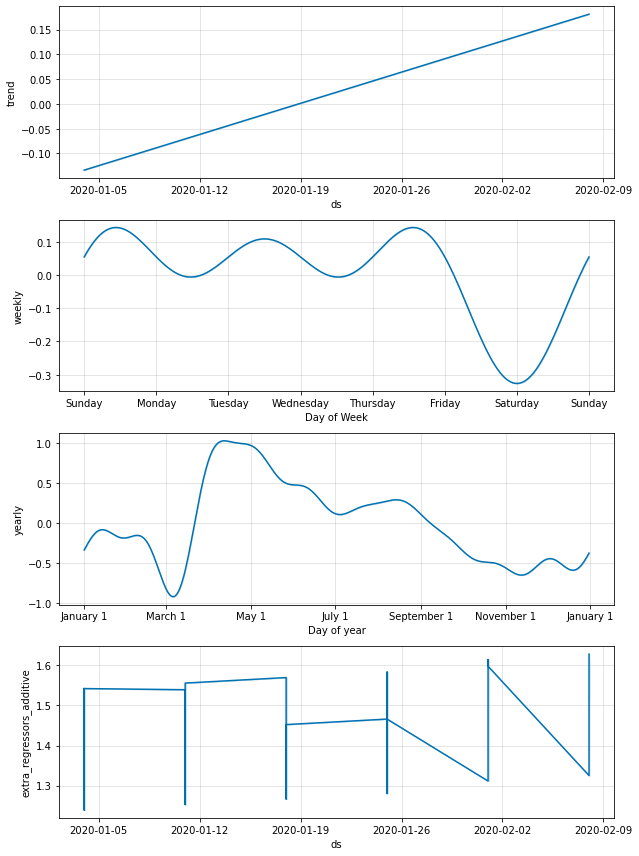

In [300]:
# Visualize the forecast components
model_optimal.plot_components(forecast_optimal);